In this notebook, I train a transformer model on the news-commentary-v16 dataset. The main purpose of this notebook is to study how the performance of the model changes as training set size increases. The result is shown in the plots at the end of this notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/workspace/transformer
!ls

Mounted at /content/drive
/content/drive/MyDrive/workspace/transformer
en_sp_model.model
en_sp_model.vocab
news-commentary-v14.en-zh.tsv
results_news-commentary-v14_only.json
saved_models_news-commentary-v14_only
Transformer_Chinese_To_English_Translation_news-commentary-v16.ipynb
zh-en_corpus_en_trainsize_100000.txt
zh-en_corpus_en_trainsize_150000.txt
zh-en_corpus_en_trainsize_200000.txt
zh-en_corpus_en_trainsize_250000.txt
zh-en_corpus_en_trainsize_300000.txt
zh-en_corpus_en_trainsize_50000.txt
zh-en_corpus_zh_trainsize_100000.txt
zh-en_corpus_zh_trainsize_150000.txt
zh-en_corpus_zh_trainsize_200000.txt
zh-en_corpus_zh_trainsize_250000.txt
zh-en_corpus_zh_trainsize_300000.txt
zh-en_corpus_zh_trainsize_50000.txt
zh_sp_model.model
zh_sp_model.vocab


In [ ]:
!pip install sentencepiece --quiet
!pip install sacrebleu --quiet
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.9 MB/s eta 0:00:00


In [ ]:
import math
from dataclasses import dataclass

import numpy as np
import sacrebleu
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from tqdm import tqdm
import pandas
torch.manual_seed(0)
import random
random.seed(0)
import  pathlib
import json
import matplotlib.pyplot as plt
from torchinfo import summary

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
SRC = "zh"
TRG = "en"
en_vocab_size = 30000
zh_vocab_size = 30000
vocab_sizes = {"en": en_vocab_size, "zh": zh_vocab_size}
max_seq_len = 50

# Get English and Chinese tokenizers

I use [SentencePiece](https://github.com/google/sentencepiece) to get both the Chinese and English tokenizers.

The news-commentary-v16 dataset can be downloaded from https://data.statmt.org/news-commentary/v16/training/.

The validation set and test set I used are simply sampled from the news-commentary-v16 dataset, both with a size of 5000.


In [ ]:
import pandas
import random
import torch
import csv # 导入 csv 模块


full_set = pandas.read_csv(
    'news-commentary-v14.en-zh.tsv',
    sep='\t',
    header=None,
    on_bad_lines='skip',  # <--- 解决方案
    quoting=csv.QUOTE_NONE # <--- 推荐的附加项
)

print("正在将 DataFrame 转换为列表...")
full_set = [(full_set[0][i], full_set[1][i]) for i in range(len(full_set[0]))
          if not isinstance(full_set[0][i], float) and not isinstance(full_set[1][i], float)]
print(f"转换完成，共 {len(full_set)} 条数据。")

# 2. 随机打乱 *所有* 数据
random.shuffle(full_set)
print("数据已打乱。")

# --- 以下是修改后的代码 ---

# 3. 定义您需要的尺寸
total_subset_size = 110380
train_size = 92073
test_size = 10000

# 4. 检查总数据量是否足够
if len(full_set) < total_subset_size:
    print(f"警告: 数据集总大小 {len(full_set)} 小于请求的 {total_subset_size}。将使用所有可用数据。")
    total_subset_size = len(full_set)

# 5. 先提取 110,380 个随机样本
subset_data = full_set[:total_subset_size]
print(f"已提取子集 {len(subset_data)} 条数据。")

# 6. 计算剩余的给 valid set
valid_size = total_subset_size - train_size - test_size

# 7. 检查尺寸是否合法
if valid_size < 0:
    raise ValueError(f"错误: 训练集 ({train_size}) + 测试集 ({test_size}) 的大小总和超过了子集大小 ({total_subset_size})。")

print(f"即将分割为: 训练集={train_size}, 测试集={test_size}, 验证集={valid_size}")

# 8. 使用 torch.utils.data.random_split 来分割 *子集*
#    注意：我们调换了 test_set 和 valid_set 的变量顺序以匹配您的要求
full_train_set, test_set, valid_set = torch.utils.data.random_split(
                                        subset_data,
                                        [train_size, test_size, valid_size],
                                        generator=torch.Generator().manual_seed(42))
# --- 修改结束 ---

# 打印结果进行验证
print(f"分割完成: 训练集 {len(full_train_set)}, 验证集 {len(valid_set)}, 测试集 {len(test_set)}")
print("--- 训练集前3个样本 ---")
for i in range(3):
    print(full_train_set[i])

正在将 DataFrame 转换为列表...
转换完成，共 311556 条数据。
数据已打乱。
已提取子集 110380 条数据。
即将分割为: 训练集=92073, 测试集=10000, 验证集=8307
分割完成: 训练集 92073, 验证集 8307, 测试集 10000
--- 训练集前3个样本 ---
('The two are intimately connected: micro-level regulation affects the supply and allocation of credit – a crucial determinant of macroeconomic activity.', '这两者相辅相成：微观层面监管影响信用的供给和配置 — — 而这是宏观经济活动的关键决定因素。')
('It has been a sadly recurrent condition of the Arab-Israeli conflict that no war lost by a humiliated Arab side has ever ushered in a peace settlement, just as no war overwhelmingly won by Israel has ever led its leaders to be magnanimous in victory.', '阿以冲突一个令人伤心的不断发生的状况就是受到羞辱的阿拉伯一方并没有因为任何一次战争的失败而达成和平协议，正如以色列所取得的任何压倒性胜利并没有使它的领导表现出胜利者的大度。')
('Corruption is widely believed to be endemic in the country’s police, secret service, administration, government, and Prosecutor’s Office.', '人们广泛认为，乌克兰警察、特务机关、行政部门、政府和检查系统普遍存在腐败现象。')


In [ ]:
def get_tokenizers(dataset, train_set_size):
    en_file = f'zh-en_corpus_en_trainsize_{train_set_size}.txt'
    zh_file = f'zh-en_corpus_zh_trainsize_{train_set_size}.txt'
    en_sp_model = f'zh-en_en_trainsize_{train_set_size}'
    zh_sp_model = f'zh-en_zh_trainsize_{train_set_size}'
    f_en = open(en_file, "w")
    f_zh = open(zh_file, "w")
    for pair in list(dataset)[0:train_set_size]:
        f_en.write(pair[0] + '\n')
        f_zh.write(pair[1] + '\n')
    f_en.close()
    f_zh.close()
    # train sentencepiece models to get tokenizers
    spm.SentencePieceTrainer.train\
        (f'--input={en_file} --model_prefix=en_sp_model  --user_defined_symbols=<pad> --vocab_size={en_vocab_size}')
    spm.SentencePieceTrainer.train\
        (f'--input={zh_file} --model_prefix=zh_sp_model --user_defined_symbols=<pad> --vocab_size={zh_vocab_size}')

    # make SentencePieceProcessor instances and load the model files
    en_sp = spm.SentencePieceProcessor()
    en_sp.load(f'en_sp_model.model')
    zh_sp = spm.SentencePieceProcessor()
    zh_sp.load(f'zh_sp_model.model')

    tokenizers = {"en": en_sp.encode_as_ids, "zh": zh_sp.encode_as_ids}
    detokenizers = {"en":en_sp.decode_ids, "zh":zh_sp.decode_ids}
    id_to_pieces = {"en":en_sp.id_to_piece, "zh":zh_sp.id_to_piece}
    return tokenizers, detokenizers, id_to_pieces

In [ ]:
tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, 50000)
print(tokenizers['zh']('这是一个测试。'))
print(tokenizers['en']('This is a test.'))
print([id_to_pieces['zh'](id) for id in range(20)])
print([id_to_pieces['en'](id) for id in range(20)])

[3267, 1874, 5]
[96, 14, 10, 1846, 6]
['<unk>', '<s>', '</s>', '<pad>', ',', '。', '▁', '的', '▁—', '和', '、', '在', '(', '是', '“', ')', '了', '对', '年', '将']
['<unk>', '<s>', '</s>', '<pad>', ',', '▁the', '.', '▁to', '▁of', '▁and', '▁a', '▁in', 's', '▁that', '▁is', '’', '-', '▁', '▁for', 'ing']


In [ ]:
# indexes of special symbols
UNK, BOS, EOS, PAD = 0, 1, 2, 3

# Data processing

In [ ]:
def tokenize_dataset(dataset):
    'tokenize a dataset and add [BOS] and [EOS] to the beginning and end of the sentences'
    if SRC == "zh":
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for trg_text, src_text in dataset]
    else:
        return [(torch.tensor([BOS]+tokenizers[SRC](src_text)[0:max_seq_len-2]+[EOS]),
                 torch.tensor([BOS]+tokenizers[TRG](trg_text)[0:max_seq_len-2]+[EOS]))
                 for src_text, trg_text in dataset]


In [ ]:
class TranslationDataset(Dataset):
    'create a dataset for torch.utils.data.DataLoader() '
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def pad_sequence(batch):
    'collate function for padding sentences such that all \
    the sentences in the batch have the same length'
    src_seqs  = [src for src, trg in batch]
    trg_seqs  = [trg for src, trg in batch]
    src_padded = torch.nn.utils.rnn.pad_sequence(src_seqs,
                                batch_first=True, padding_value = PAD)
    trg_padded = torch.nn.utils.rnn.pad_sequence(trg_seqs,
                                batch_first=True, padding_value = PAD)
    return src_padded, trg_padded


In [ ]:
batch_size = 128

class Dataloaders:
    'Dataloaders contains train_loader, test_loader and valid_loader for training and evaluation '
    def __init__(self, train_set_size):
        train_set = list(full_train_set)[0:train_set_size]
        train_dataset = TranslationDataset(tokenize_dataset(train_set))
        valid_dataset = TranslationDataset(tokenize_dataset(valid_set))
        test_dataset  = TranslationDataset(tokenize_dataset(test_set))

        # each batch returned by dataloader will be padded such that all the texts in
        # that batch have the same length as the longest text in that batch
        self.train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn = pad_sequence)

        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)

        self.valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                                shuffle=True, collate_fn=pad_sequence)


# Transformer Model

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size
        # 1) Linear projections to get the multi-head query, key and value tensors
        # x_query, x_key, x_value dimension: nbatch * seq_len * d_embed
        # LHS query, key, value dimensions: nbatch * h * seq_len * d_k
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        # 2) Attention
        # scores has dimensions: nbatch * h * seq_len * seq_len
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        # 3) Mask out padding tokens and future tokens
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        # p_atten dimensions: nbatch * h * seq_len * seq_len
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        # x dimensions: nbatch * h * seq_len * d_k
        x = torch.matmul(p_atten, value)
        # x now has dimensions:nbtach * seq_len * d_embed
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x) # final linear layer


class ResidualConnection(nn.Module):
  '''residual connection: x + dropout(sublayer(layernorm(x))) '''
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))

# I simply let the model learn the positional embeddings in this notebook, since this
# almost produces identital results as using sin/cosin functions embeddings, as claimed
# in the original transformer paper. Note also that in the original paper, they multiplied
# the token embeddings by a factor of sqrt(d_embed), which I do not do here.

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)


class EncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)


class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)

    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class DecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout)
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # keys and values are from the encoder output
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

In [ ]:
@dataclass
class ModelConfig:
    encoder_vocab_size: int
    decoder_vocab_size: int
    d_embed: int
    # d_ff is the dimension of the fully-connected  feed-forward layer
    d_ff: int
    # h is the number of attention head
    h: int
    N_encoder: int
    N_decoder: int
    max_seq_len: int
    dropout: float

def make_model(config):
    model = Transformer(Encoder(config), Decoder(config)).to(DEVICE)

    # initialize model parameters
    # it seems that this initialization is very important!
    for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    return model

# Training and evaluation helper functions

In [ ]:
def make_batch_input(x, y):
        src = x.to(DEVICE)
        trg_in = y[:, :-1].to(DEVICE)
        trg_out = y[:, 1:].contiguous().view(-1).to(DEVICE)
        src_pad_mask = (src == PAD).view(src.size(0), 1, 1, src.size(-1))
        trg_pad_mask = (trg_in == PAD).view(trg_in.size(0), 1, 1, trg_in.size(-1))
        return src, trg_in, trg_out, src_pad_mask, trg_pad_mask

In [ ]:
def train_epoch(model, dataloaders):
    model.train()
    grad_norm_clip = 1.0
    losses, acc, count = [], 0, 0
    num_batches = len(dataloaders.train_loader)
    pbar = tqdm(enumerate(dataloaders.train_loader), total=num_batches)
    for idx, (x, y)  in  pbar:
        optimizer.zero_grad()
        src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
        pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
        pred = pred.view(-1, pred.size(-1))
        loss = loss_fn(pred, trg_out).to(DEVICE)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        # report progress
        if idx>0 and idx%50 == 0:
            pbar.set_description(f'train loss={loss.item():.3f}, lr={scheduler.get_last_lr()[0]:.5f}')
    return np.mean(losses)


def train(model, dataloaders, epochs = 10):
    global early_stop_count
    best_valid_loss = float('inf')
    train_size = len(dataloaders.train_loader)*batch_size
    for ep in range(epochs):
        train_loss = train_epoch(model, dataloaders)
        valid_loss = validate(model, dataloaders.valid_loader)

        print(f'ep: {ep}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
        else:
            if scheduler.last_epoch>1.5*warmup_steps:
                early_stop_count -= 1
                if early_stop_count<=0:
                    return train_loss, valid_loss
    return train_loss, valid_loss


def validate(model, dataloder):
    'compute the validation loss'
    model.eval()
    losses = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloder):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            pred = model(src, src_pad_mask, trg_in, trg_pad_mask).to(DEVICE)
            pred = pred.view(-1, pred.size(-1))
            losses.append(loss_fn(pred, trg_out).item())
    return np.mean(losses)

In [ ]:
def translate(model, x):
    'translate source sentences into the target language, without looking at the answer'
    with torch.no_grad():
        dB = x.size(0)
        y = torch.tensor([[BOS]*dB]).view(dB, 1).to(DEVICE)
        x_pad_mask = (x == PAD).view(x.size(0), 1, 1, x.size(-1)).to(DEVICE)
        memory = model.encoder(x, x_pad_mask)
        for i in range(max_seq_len):
            y_pad_mask = (y == PAD).view(y.size(0), 1, 1, y.size(-1)).to(DEVICE)
            logits = model.decoder(memory, x_pad_mask, y, y_pad_mask)
            last_output = logits.argmax(-1)[:, -1]
            last_output = last_output.view(dB, 1)
            y = torch.cat((y, last_output), 1).to(DEVICE)
    return y

In [ ]:
def remove_pad(sent):
    '''truncate the sentence if BOS is in it,
     otherwise simply remove the padding tokens at the end'''
    if sent.count(EOS)>0:
      sent = sent[0:sent.index(EOS)+1]
    while sent and sent[-1] == PAD:
            sent = sent[:-1]
    return sent

def decode_sentence(detokenizer, sentence_ids):
    'convert a tokenized sentence (a list of numbers) to a literal string'
    if not isinstance(sentence_ids, list):
        sentence_ids = sentence_ids.tolist()
    sentence_ids = remove_pad(sentence_ids)
    return detokenizer(sentence_ids).replace("<bos>", "")\
           .replace("<eos>", "").strip().replace(" .", ".")

def evaluate(model, dataloader, num_batch=None):
    'evaluate the model, and compute the BLEU score'
    model.eval()
    refs, cans, bleus = [], [], []
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataloader):
            src, trg_in, trg_out, src_pad_mask, trg_pad_mask = make_batch_input(x,y)
            translation = translate(model, src)
            trg_out = trg_out.view(x.size(0), -1)
            refs = refs + [decode_sentence(detokenizers[TRG], trg_out[i]) for i in range(len(src))]
            cans = cans + [decode_sentence(detokenizers[TRG], translation[i]) for i in range(len(src))]
            if num_batch and idx>=num_batch:
                break
        bleus.append(sacrebleu.corpus_bleu(cans, [refs]).score)
        # print some examples
        for i in range(3):
            print(f'src:  {decode_sentence(detokenizers[SRC], src[i])}')
            print(f'trg:  {decode_sentence(detokenizers[TRG], trg_out[i])}')
            print(f'pred: {decode_sentence(detokenizers[TRG], translation[i])}')
        return np.mean(bleus)

# Training

In [ ]:
config = ModelConfig(encoder_vocab_size = vocab_sizes[SRC],
                     decoder_vocab_size=vocab_sizes[TRG],
                     d_embed=512,
                     d_ff=2048,
                     h=8,
                     N_encoder=6,
                     N_decoder=6,
                     max_seq_len=max_seq_len,
                     dropout=0.1
                     )
results = {}
for train_size in  np.array([5, 10, 15, 20, 25, 30])*10000:
    tokenizers, detokenizers, id_to_pieces = get_tokenizers(full_train_set, train_size)
    data_loaders = Dataloaders(train_size)
    model = make_model(config)
    model_size = sum([p.numel() for p in model.parameters()])
    print(f'model_size: {model_size}, train_set_size: {train_size}')
    warmup_steps = 4*len(data_loaders.train_loader)
    # lr first increases in the warmup steps, and then descreases
    lr_fn = lambda step: config.d_embed**(-0.5) * min([(step+1)**(-0.5), (step+1)*warmup_steps**(-1.5)])
    optimizer = torch.optim.Adam(model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_fn)
    loss_fn = nn.CrossEntropyLoss(ignore_index=PAD)
    early_stop_count = 2
    train_loss, valid_loss = train(model, data_loaders, epochs=30)
    test_loss  = validate(model, data_loaders.test_loader)

    print("train set examples:")
    train_bleu = evaluate(model, data_loaders.train_loader, 20)
    print("validation set examples:")
    valid_bleu = evaluate(model, data_loaders.valid_loader)
    print("test set examples:")
    test_bleu  = evaluate(model, data_loaders.test_loader)
    results[f'model_size={model_size}, train_size={train_size}'] = {
                                        'train_loss': train_loss,
                                        'valid_loss': valid_loss,
                                        'test_loss' : test_loss,
                                        'train_bleu': train_bleu,
                                        'valid_bleu': valid_bleu,
                                        'test_bleu': test_bleu}
    f = open('results_news-commentary-v14_only.json', 'w')
    json.dump(results, f)
    f.close()
    torch.save(model, f'saved_models_news-commentary-v14_only/{SRC}_to_{TRG}_dataset_size_{train_size}_model_size_{model_size}.pt')
    print(f'train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, test_loss: {test_loss:.4f}')
    print(f'test_bleu: {test_bleu:.4f}, valid_bleu: {valid_bleu:.4f} train_bleu: {train_bleu:.4f}')

model_size: 90301744, train_set_size: 50000


train loss=5.813, lr=0.00025: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 0: train_loss=7.15104, valid_loss=5.68886


train loss=4.949, lr=0.00053: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 1: train_loss=5.25059, valid_loss=4.94376


train loss=4.493, lr=0.00081: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 2: train_loss=4.55509, valid_loss=4.49435


train loss=4.162, lr=0.00109: 100%|██████████| 391/391 [01:07<00:00,  5.78it/s]


ep: 3: train_loss=4.05187, valid_loss=4.18958


train loss=3.630, lr=0.00101: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 4: train_loss=3.58973, valid_loss=3.91115


train loss=3.201, lr=0.00092: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 5: train_loss=3.09626, valid_loss=3.73014


train loss=2.780, lr=0.00085: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 6: train_loss=2.67559, valid_loss=3.65504


train loss=2.429, lr=0.00080: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 7: train_loss=2.31100, valid_loss=3.64460


train loss=2.128, lr=0.00075: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 8: train_loss=1.98967, valid_loss=3.68928


train loss=1.764, lr=0.00071: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


ep: 9: train_loss=1.70878, valid_loss=3.76382
train set examples:
src:  于是,美国汽车业工人联合会和钢铁工人联合会不顾企业利益集团的强烈反对,向国会请愿,要求建立退休基金保险公司,以确保当公司不能履行承诺的时候个人的养老金计划得以实现。
trg:  The AFL-CIO, the United Auto Workers and the United Steel Workers then petitioned Congress – against strong opposition from business interests – to establish the Pension Benefit Guaranty Corporation in 1974 to insure private pensions against companies’ failure
pred: As a result, the US Department of Workers and the National Workers’ Office Congressional Workers’ Office Congressional allies, which openly demands a fair plan to ensure that the Department of Homeland Security company cannot fulfill its commitment to public pensions.
src:  即使合理地估计了来自经济增长的税收收入增量,他仍然需要通过控制支出,特别是福利支出与其减税计划匹配。
trg:  If properly scored to account for increased tax revenue from economic growth, he would still need to pair his tax cuts with controls on spending, and especially on entitlements.
pred: Even if appropriate cuts are made to economic growth, he

train loss=5.457, lr=0.00020: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 0: train_loss=6.90757, valid_loss=5.45791


train loss=4.725, lr=0.00041: 100%|██████████| 720/720 [02:04<00:00,  5.77it/s]


ep: 1: train_loss=5.00018, valid_loss=4.54907


train loss=4.003, lr=0.00061: 100%|██████████| 720/720 [02:04<00:00,  5.77it/s]


ep: 2: train_loss=4.16110, valid_loss=3.88317


train loss=3.434, lr=0.00082: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 3: train_loss=3.51849, valid_loss=3.45372


train loss=2.818, lr=0.00074: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 4: train_loss=3.02593, valid_loss=3.10179


train loss=2.652, lr=0.00067: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 5: train_loss=2.59144, valid_loss=2.89753


train loss=2.217, lr=0.00062: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 6: train_loss=2.25974, valid_loss=2.79668


train loss=2.007, lr=0.00058: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 7: train_loss=1.99218, valid_loss=2.77809


train loss=1.918, lr=0.00055: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 8: train_loss=1.76426, valid_loss=2.77763


train loss=1.650, lr=0.00052: 100%|██████████| 720/720 [02:04<00:00,  5.77it/s]


ep: 9: train_loss=1.56705, valid_loss=2.81688


train loss=1.477, lr=0.00050: 100%|██████████| 720/720 [02:04<00:00,  5.77it/s]


ep: 10: train_loss=1.39326, valid_loss=2.86295
train set examples:
src:  这必将导致以色列对伊朗核设施发动先发制人打击 — — 美国则会默许甚至参与。
trg:  This would all but guarantee that Israel would launch a pre-emptive strike on Iran’s nuclear installations – with America’s blessing, if not complicity.
pred: This would certainly lead to a reassessment in Israel’s nuclear installations – the US will seize even its entry.
src:  1931年的“满洲里事件”最终导致日本占领东北三省,日本商人召妓正发生在该事件72周年纪念日。 在一个互联网民意测验中90%的投票者表示他们坚信日本商人是故意要籍此羞辱中国。
trg:  Occurring on the 72nd anniversary of the 1931 Mukden Incident that led to the Japanese occupation of Manchuria, 90% of Chinese respondents to an Internet poll said they believed that the Japanese businessmen intended to humiliate China.
pred: The 1931 Sino-Japanese drama of 1931, which resulted in the destruction of Japanese occupation, was confirming that, in a consumer poll, 90% of the consumer poll in a Internet poll said that they believed that their Japanese businessmen were deliberately designed
sr

train loss=5.457, lr=0.00020: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 0: train_loss=6.91394, valid_loss=5.48136


train loss=4.631, lr=0.00041: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 1: train_loss=5.00878, valid_loss=4.55222


train loss=4.004, lr=0.00061: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 2: train_loss=4.15287, valid_loss=3.87576


train loss=3.389, lr=0.00082: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 3: train_loss=3.51467, valid_loss=3.44873


train loss=2.887, lr=0.00074: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 4: train_loss=3.01995, valid_loss=3.08427


train loss=2.760, lr=0.00067: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 5: train_loss=2.57984, valid_loss=2.89926


train loss=2.223, lr=0.00062: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 6: train_loss=2.25061, valid_loss=2.79413


train loss=2.051, lr=0.00058: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 7: train_loss=1.98360, valid_loss=2.76318


train loss=1.870, lr=0.00055: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 8: train_loss=1.75699, valid_loss=2.76284


train loss=1.702, lr=0.00052: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 9: train_loss=1.56031, valid_loss=2.79975


train loss=1.553, lr=0.00050: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 10: train_loss=1.39047, valid_loss=2.85013
train set examples:
src:  在一个通缩环境中,低油价似乎令欧洲央行更难以实现其近2%的通胀目标。
trg:  In a deflationary environment, lower oil prices appear to make it more difficult for the European Central Bank to achieve its target of an inflation rate close to 2%.
pred: In a deflationary environment, low oil prices seem to make it more difficult for the ECB to fulfill its target of nearly 2% inflation.
src:  关键在于服务业最终得和高速生产率增长的金融业、制造业和信息技术行业在同一个国家的劳动力市场里争夺劳动力。
trg:  The problem is that service industries ultimately have to compete for workers in the same national labor pool as sectors with fast productivity growth, such as finance, manufacturing, and information technology.
pred: The key is services that ultimately serve and invest in high-growth productivity growth, manufacturing, and information-technology industries in the same country.
src:  幸运的是,它似乎正在选择灵活和调整之路,追求一个宏大的改革计划,我们希望这能让中国更加接近 — — 并最终迈过 — — 高收入门槛。
trg:  Fortunately, it seems to be choosing the path of flex

train loss=5.563, lr=0.00020: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 0: train_loss=6.89905, valid_loss=5.46557


train loss=4.702, lr=0.00041: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 1: train_loss=4.99186, valid_loss=4.53743


train loss=3.910, lr=0.00061: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 2: train_loss=4.15335, valid_loss=3.89958


train loss=3.417, lr=0.00082: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 3: train_loss=3.53358, valid_loss=3.46588


train loss=3.179, lr=0.00074: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 4: train_loss=3.03629, valid_loss=3.10324


train loss=2.653, lr=0.00067: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 5: train_loss=2.59071, valid_loss=2.90883


train loss=2.315, lr=0.00062: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 6: train_loss=2.25679, valid_loss=2.81411


train loss=2.105, lr=0.00058: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 7: train_loss=1.98543, valid_loss=2.77887


train loss=1.860, lr=0.00055: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 8: train_loss=1.75661, valid_loss=2.78396


train loss=1.690, lr=0.00052: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 9: train_loss=1.55882, valid_loss=2.82552
train set examples:
src:  即使是带有明确目的的计划也有可能适得其反:几年前,欧洲带着良好的意愿尝试刺激可再生能源投资,结果导致了宏观经济出现太阳能泡沫。
trg:  Even seemingly purposeful projects can seriously backfire: only a few years ago, Europe’s well-intentioned efforts to stimulate renewables resulted in a solar energy bubble of macroeconomic proportions.
pred: Even the proposed plan that is clearly intended, may be counterproductive years ago: Europe’s well-intentioned efforts to stimulate renewables investment, which led to a macroeconomic bubble.
src:  皮克提也承认,他的方案 — — 累进的全球资本(或财富)税 — — “要求极高水平的国际合作,这显然是不现实的。 ”
trg:  As Piketty admits, his proposal – a progressive global tax on capital (or wealth) – “would require a very high and no doubt unrealistic level of international cooperation.”
pred: Piketty admits that his proposal – the progressive global tax (or wealth) tax – “would require a very high level of international cooperation,” apparently unrealisticly.
src:  这或许是因为该政权并不像它看上去那般坦然无惧。
trg:  P

train loss=5.540, lr=0.00020: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 0: train_loss=6.90975, valid_loss=5.48264


train loss=4.515, lr=0.00041: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 1: train_loss=5.00099, valid_loss=4.53231


train loss=3.923, lr=0.00061: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 2: train_loss=4.15647, valid_loss=3.92561


train loss=3.483, lr=0.00082: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 3: train_loss=3.54129, valid_loss=3.47121


train loss=2.978, lr=0.00074: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 4: train_loss=3.03676, valid_loss=3.10449


train loss=2.588, lr=0.00067: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 5: train_loss=2.58921, valid_loss=2.91460


train loss=2.239, lr=0.00062: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 6: train_loss=2.25141, valid_loss=2.80412


train loss=2.013, lr=0.00058: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 7: train_loss=1.97884, valid_loss=2.77136


train loss=1.811, lr=0.00055: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 8: train_loss=1.74761, valid_loss=2.77849


train loss=1.691, lr=0.00052: 100%|██████████| 720/720 [02:05<00:00,  5.74it/s]


ep: 9: train_loss=1.54957, valid_loss=2.82380
train set examples:
src:  在生产和消耗之间取得更佳的平衡,可以避免油价的大幅摇摆。
trg:  A better balance between production and consumption would avoid large swings in oil prices.
pred: A better balance between production and consumption would avoid a sharp break with the oil price.
src:  但仍有很多方面值得担忧。
trg:  Yet there remains plenty of cause for concern.
pred: But there are plenty of reasons for concern.
src:  全球绿色新政
trg:  A Global Green New Deal
pred: The Global Green New Deal
validation set examples:
src:  但有一个关键不同点:意大利是不需要外部援助资金的精英俱乐部的一员。
trg:  But there is one crucial difference: Italy is part of a select club that does not need outside rescue funds.
pred: But there is a crucial point: Italy is no longer a party that does not need external aid to the elite.
src:  过去十年来,考虑风险时的重点从阻止新的国家获得核武器转变为阻止恐怖组织和其他非国家行动方获得核武器(或其关键成分 ) 。
trg:  In considering the risks, the emphasis has shifted over the last decade from preventing additional states from acquiring nuclear weapons 

train loss=5.497, lr=0.00020: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 0: train_loss=6.90832, valid_loss=5.47510


train loss=4.670, lr=0.00041: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 1: train_loss=4.98661, valid_loss=4.54404


train loss=3.825, lr=0.00061: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 2: train_loss=4.15219, valid_loss=3.90544


train loss=3.346, lr=0.00082: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 3: train_loss=3.53356, valid_loss=3.45450


train loss=3.031, lr=0.00074: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 4: train_loss=3.04522, valid_loss=3.11992


train loss=2.685, lr=0.00067: 100%|██████████| 720/720 [02:05<00:00,  5.76it/s]


ep: 5: train_loss=2.60912, valid_loss=2.91269


train loss=2.344, lr=0.00062: 100%|██████████| 720/720 [02:04<00:00,  5.76it/s]


ep: 6: train_loss=2.27486, valid_loss=2.82722


train loss=2.019, lr=0.00058: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 7: train_loss=2.00428, valid_loss=2.78634


train loss=1.781, lr=0.00055: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 8: train_loss=1.77703, valid_loss=2.79776


train loss=1.684, lr=0.00052: 100%|██████████| 720/720 [02:05<00:00,  5.75it/s]


ep: 9: train_loss=1.57837, valid_loss=2.83755
train set examples:
src:  考虑到利比亚缺乏民主经验,有人认为停滞将成为后卡扎菲时代最有可能的结果。
trg:  Given Libya’s lack of democratic experience, some view this as a likely outcome in the post- ⁇ addafi era.
pred: Given Libya’s lack of democratic experience, some view that it will be the most likely outcome of post- ⁇ addafi era.
src:  这包括处理法国阿尔及利亚后裔的问题,不用说阿尔及利亚本身的问题,化解矛盾似乎很难成功。
trg:  It is with the French of Algerian descent, not to mention Algeria itself, that reconciliation seems most difficult to achieve.
pred: This, of course, is a matter of dealing with French descendants, not to mention Algeria itself, and the conflict seems to be difficult.
src:  比如:
trg:  For example:
pred: For example:
validation set examples:
src:  这场韩国政治危机始于2016年10月,有人指控朴槿惠施压财阀 — — 韩国巨型家族企业集团 — — 将巨额资金转入由其密友崔顺实控制的两家基金会。
trg:  South Korea’s current political crisis began in October 2016, when allegations emerged that Park had pressured the chaebols – the country’s giant family-owned conglomerat

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
Transformer                                             --
├─Encoder: 1-1                                          25,600
│    └─Embedding: 2-1                                   15,360,000
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderBlock: 3-1                           3,152,384
│    │    └─EncoderBlock: 3-2                           3,152,384
│    │    └─EncoderBlock: 3-3                           3,152,384
│    │    └─EncoderBlock: 3-4                           3,152,384
│    │    └─EncoderBlock: 3-5                           3,152,384
│    │    └─EncoderBlock: 3-6                           3,152,384
│    └─Dropout: 2-3                                     --
│    └─LayerNorm: 2-4                                   1,024
├─Decoder: 1-2                                          25,600
│    └─Embedding: 2-5                                   15,360,000
│    └─Dropout: 2-6                      

# Scaling and extrapolation

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
f = open('results_news-commentary-v14_only.json', 'r')
res = json.load(f)
print(res)

{'model_size=90301744, train_size=50000': {'train_loss': 1.7087835411891303, 'valid_loss': 3.763824129104614, 'test_loss': 3.784249978729441, 'train_bleu': 22.265583062416592, 'valid_bleu': 9.146936293116346, 'test_bleu': 9.073271052298791}, 'model_size=90301744, train_size=100000': {'train_loss': 1.393262834350268, 'valid_loss': 2.862954231408926, 'test_loss': 2.8937241638763043, 'train_bleu': 31.81811839917423, 'valid_bleu': 15.317019630789884, 'test_bleu': 15.266181737608855}, 'model_size=90301744, train_size=150000': {'train_loss': 1.390468791127205, 'valid_loss': 2.8501294722923864, 'test_loss': 2.8752044363866878, 'train_bleu': 32.31176194111124, 'valid_bleu': 15.47516770790225, 'test_bleu': 15.189356656350974}, 'model_size=90301744, train_size=200000': {'train_loss': 1.558817899061574, 'valid_loss': 2.825520210999709, 'test_loss': 2.8562268577044523, 'train_bleu': 28.414083540896122, 'valid_bleu': 15.306345187256516, 'test_bleu': 15.072205620895621}, 'model_size=90301744, train_

In [ ]:
sizes = []
test_losses = []
test_bleus = []

for size in np.array([5, 10, 15, 20, 25, 30])*10000:
    result = res['model_size=90301744, train_size='+str(size)]
    print(f'model_size=90301744, train_size={str(size)}:')
    print(result)
    sizes.append(size)
    test_losses.append(result['test_loss'])
    test_bleus.append(result['test_bleu'])


model_size=90301744, train_size=50000:
{'train_loss': 1.7087835411891303, 'valid_loss': 3.763824129104614, 'test_loss': 3.784249978729441, 'train_bleu': 22.265583062416592, 'valid_bleu': 9.146936293116346, 'test_bleu': 9.073271052298791}
model_size=90301744, train_size=100000:
{'train_loss': 1.393262834350268, 'valid_loss': 2.862954231408926, 'test_loss': 2.8937241638763043, 'train_bleu': 31.81811839917423, 'valid_bleu': 15.317019630789884, 'test_bleu': 15.266181737608855}
model_size=90301744, train_size=150000:
{'train_loss': 1.390468791127205, 'valid_loss': 2.8501294722923864, 'test_loss': 2.8752044363866878, 'train_bleu': 32.31176194111124, 'valid_bleu': 15.47516770790225, 'test_bleu': 15.189356656350974}
model_size=90301744, train_size=200000:
{'train_loss': 1.558817899061574, 'valid_loss': 2.825520210999709, 'test_loss': 2.8562268577044523, 'train_bleu': 28.414083540896122, 'valid_bleu': 15.306345187256516, 'test_bleu': 15.072205620895621}
model_size=90301744, train_size=250000:
{

In [ ]:
num_tokens = []
for num_sentences in np.array([5, 10, 15, 20, 25, 30])*10000:
    num_tokens.append(sum([len(x[0]) for x in tokenize_dataset(list(full_train_set)[0:num_sentences])]))
sizes = num_tokens

/tmp/ipython-input-4151963834.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params, _ = curve_fit(linear_fn, logsize[2:], logloss[2:])
/tmp/ipython-input-4151963834.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  fit_params, _ =curve_fit(linear_fn, oneoversizes[2:], test_bleus[2:])


[ -70.37544889 1025.81756895]
[ 1.         15.00350819]


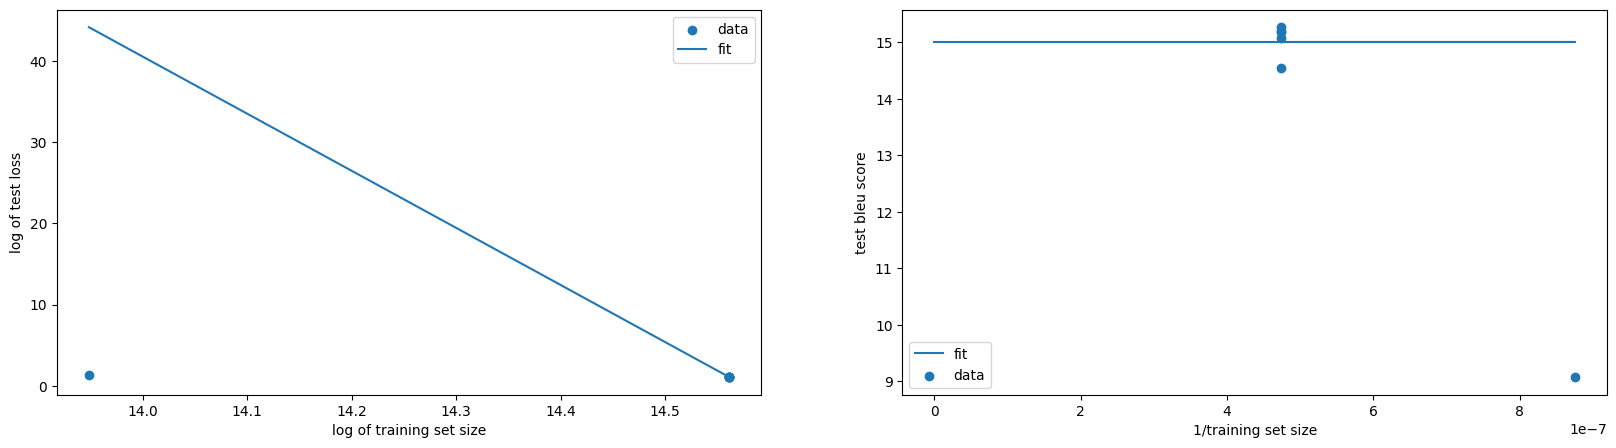

In [ ]:
def linear_fn(x, a, b):
    return a*x + b

fig, ax = plt.subplots(1, 2, figsize=(20,5))

logsize = np.log(sizes)
logloss = np.log(test_losses)
fit_params, _ = curve_fit(linear_fn, logsize[2:], logloss[2:])
print(fit_params)

loss_fitted_data = linear_fn(logsize, fit_params[0], fit_params[1])
ax[0].scatter(logsize, logloss, label='data')
ax[0].plot(logsize, loss_fitted_data, label='fit')
ax[0].set_xlabel('log of training set size')
ax[0].set_ylabel('log of test loss')
ax[0].legend()

oneoversizes = np.reciprocal(np.array(sizes, dtype=float))
fit_params, _ =curve_fit(linear_fn, oneoversizes[2:], test_bleus[2:])
print(fit_params)
bleu_fitted_data = linear_fn(np.insert(oneoversizes, 0, 0, 0), fit_params[0], fit_params[1])

ax[1].plot(np.insert(oneoversizes, 0, 0, 0), bleu_fitted_data, label='fit')
ax[1].scatter(np.reciprocal(np.array(sizes, dtype=float)), test_bleus,  label='data')
ax[1].set_xlabel('1/training set size')
ax[1].set_ylabel('test bleu score')
ax[1].legend()
plt.show()

#Inference

In [ ]:
# ----------------------------------------------------
# 单元格 1：安装依赖
# ----------------------------------------------------
!pip install torch --quiet
!pip install altair pandas --quiet
!pip install sacrebleu --quiet
!pip install sentencepiece --quiet

print("✅ 依赖安装完毕！")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.7 MB/s eta 0:00:00
✅ 依赖安装完毕！


In [ ]:
# ----------------------------------------------------
# 单元格 2：指定文件路径 (替换上传)
# ----------------------------------------------------
import os

# --- ‼️ 请在此处编辑你的文件路径 ‼️ ---

# 示例路径 (如果你已挂载 Google Drive):
# DRIVE_DIR = "/content/drive/MyDrive/MyNMTProject/"

# 或者，如果你把文件放在了 Colab 的根目录:
DRIVE_DIR = "./"

# 1. 你的模型权重
MODEL_FILE_PATH = os.path.join(DRIVE_DIR, "model.pt")

# 2. 你的英文分词器
EN_SP_MODEL_PATH = os.path.join(DRIVE_DIR, "en_sp_model.model")

# 3. 你的中文分词器
ZH_SP_MODEL_PATH = os.path.join(DRIVE_DIR, "zh_sp_model.model")

# --- 检查文件是否存在 ---
print("正在检查文件...")
all_files_found = True
for path in [MODEL_FILE_PATH, EN_SP_MODEL_PATH, ZH_SP_MODEL_PATH]:
    if not os.path.exists(path):
        print(f"❌ 错误: 未能在 '{path}' 找到文件。")
        print("请确保已挂载 Google Drive (如果需要) 并且路径正确。")
        all_files_found = False
    else:
        print(f"✅ 找到: {path}")

if not all_files_found:
    raise FileNotFoundError("一个或多个文件未找到。请停止并修复单元格 2 中的路径。")

正在检查文件...
✅ 找到: ./model.pt
✅ 找到: ./en_sp_model.model
✅ 找到: ./zh_sp_model.model


In [ ]:
# ----------------------------------------------------
# 单元格 3：写入 *原始* model.py (用于修复加载错误)
# ----------------------------------------------------
%%writefile original_model.py
import torch
import torch.nn as nn
import math

# --- 常量 ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------
# 这是你提供的 *未经修改* 的模型代码
# torch.load 将在这里寻找类的定义
# ----------------------------------------------------

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_embed, dropout=0.0):
        super(MultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0)
        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask, float('-inf'))
        p_atten = torch.nn.functional.softmax(scores, dim=-1)
        p_atten = self.dropout(p_atten)
        x = torch.matmul(p_atten, value)
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x)

class ResidualConnection(nn.Module):
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.encoder_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)

class EncoderBlock(nn.Module):
    def __init__(self, config):
        super(EncoderBlock, self).__init__()
        self.atten = MultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        return self.residual2(x, self.feed_forward)

class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.dropout = nn.Dropout(config.dropout)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)

    def future_mask(self, seq_len):
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))
        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits

class DecoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.atten1 = MultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = MultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout)
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        return self.residuals[2](y, self.feed_forward)

class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)

print("✅ 'original_model.py' 已写入。")

Writing original_model.py


In [ ]:
%%writefile model_vis.py

import torch
import torch.nn as nn
import math

# --- 常量 (从你的代码推断) ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------
# 1. 我们需要一个 *可观察* 的 MultiHeadedAttention
# ----------------------------------------------------
class VisualizableMultiHeadedAttention(nn.Module):
    # 这个类 1:1 复制了你的 MultiHeadedAttention
    # 只增加了一行来保存 'p_atten'
    def __init__(self, h, d_embed, dropout=0.0):
        super(VisualizableMultiHeadedAttention, self).__init__()
        assert d_embed % h == 0 # check the h number
        self.d_k = d_embed//h
        self.d_embed = d_embed
        self.h = h
        self.WQ = nn.Linear(d_embed, d_embed)
        self.WK = nn.Linear(d_embed, d_embed)
        self.WV = nn.Linear(d_embed, d_embed)
        self.linear = nn.Linear(d_embed, d_embed)
        self.dropout = nn.Dropout(dropout)

        # 【关键修改】添加一个属性来存储注意力
        self.attn = None

    def forward(self, x_query, x_key, x_value, mask=None):
        nbatch = x_query.size(0) # get batch size

        query = self.WQ(x_query).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        key   = self.WK(x_key).view(nbatch, -1, self.h, self.d_k).transpose(1,2)
        value = self.WV(x_value).view(nbatch, -1, self.h, self.d_k).transpose(1,2)

        scores = torch.matmul(query, key.transpose(-2, -1))/math.sqrt(self.d_k)

        if mask is not None:
            # 你的 'make_batch_input' 掩码形状是 (B, 1, 1, S)
            # 你的 'Decoder.future_mask' 掩码形状是 (1, 1, T, T)
            # 这与 'scores' (B, H, T, T) 或 (B, H, T, S) 兼容
            scores = scores.masked_fill(mask, float('-inf'))

        p_atten = torch.nn.functional.softmax(scores, dim=-1)

        # 【关键修改】保存注意力权重 (形状: nbatch * h * seq_len * seq_len)
        self.attn = p_atten

        p_atten = self.dropout(p_atten)
        x = torch.matmul(p_atten, value)
        x = x.transpose(1, 2).contiguous().view(nbatch, -1, self.d_embed)
        return self.linear(x)

# ----------------------------------------------------
# 2. 复制你的所有其他类，不做修改
# ----------------------------------------------------

class ResidualConnection(nn.Module):
  '''residual connection: x + dropout(sublayer(layernorm(x))) '''
  def __init__(self, dim, dropout):
      super().__init__()
      self.drop = nn.Dropout(dropout)
      self.norm = nn.LayerNorm(dim)

  def forward(self, x, sublayer):
      return x + self.drop(sublayer(self.norm(x)))

class Encoder(nn.Module):
    '''Encoder = token embedding + positional embedding -> a stack of N EncoderBlock -> layer norm'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.encoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        # 【修改】使用 VisualizableEncoderBlock
        self.encoder_blocks = nn.ModuleList([VisualizableEncoderBlock(config) for _ in range(config.N_encoder)])
        self.dropout = nn.Dropout(config.dropout)
        self.norm = nn.LayerNorm(config.d_embed)

    def forward(self, input, mask=None):
        x = self.tok_embed(input)
        x_pos = self.pos_embed[:, :x.size(1), :]
        x = self.dropout(x + x_pos)
        for layer in self.encoder_blocks:
            x = layer(x, mask)
        return self.norm(x)

# ----------------------------------------------------
# 3. 创建 *可观察* 的 Block 类
# ----------------------------------------------------

class VisualizableEncoderBlock(nn.Module):
    '''EncoderBlock: self-attention -> position-wise fully connected feed-forward layer'''
    def __init__(self, config):
        super(VisualizableEncoderBlock, self).__init__()
        # 【修改】使用 VisualizableMultiHeadedAttention
        self.atten = VisualizableMultiHeadedAttention(config.h, config.d_embed, config.dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residual1 = ResidualConnection(config.d_embed, config.dropout)
        self.residual2 = ResidualConnection(config.d_embed, config.dropout)

    def forward(self, x, mask=None):
        # self-attention
        x = self.residual1(x, lambda x: self.atten(x, x, x, mask=mask))
        # position-wise fully connected feed-forward layer
        return self.residual2(x, self.feed_forward)

class Decoder(nn.Module):
    '''Decoder = token embedding + positional embedding -> a stack of N DecoderBlock -> fully-connected layer'''
    def __init__(self, config):
        super().__init__()
        self.d_embed = config.d_embed
        self.tok_embed = nn.Embedding(config.decoder_vocab_size, config.d_embed)
        self.pos_embed = nn.Parameter(torch.zeros(1, config.max_seq_len, config.d_embed))
        self.dropout = nn.Dropout(config.dropout)
        # 【修改】使用 VisualizableDecoderBlock
        self.decoder_blocks = nn.ModuleList([VisualizableDecoderBlock(config) for _ in range(config.N_decoder)])
        self.norm = nn.LayerNorm(config.d_embed)
        self.linear = nn.Linear(config.d_embed, config.decoder_vocab_size)

    def future_mask(self, seq_len):
        '''mask out tokens at future positions'''
        mask = (torch.triu(torch.ones(seq_len, seq_len, requires_grad=False), diagonal=1)!=0).to(DEVICE)
        # 匹配你的 (B, 1, 1, S) 掩码，我们需要 (1, 1, T, T)
        return mask.view(1, 1, seq_len, seq_len)

    def forward(self, memory, src_mask, trg, trg_pad_mask):
        seq_len = trg.size(1)
        # 这是你代码中的逻辑
        trg_mask = torch.logical_or(trg_pad_mask, self.future_mask(seq_len))

        x = self.tok_embed(trg) + self.pos_embed[:, :trg.size(1), :]
        x = self.dropout(x)
        for layer in self.decoder_blocks:
            x = layer(memory, src_mask, x, trg_mask)
        x = self.norm(x)
        logits = self.linear(x)
        return logits


class VisualizableDecoderBlock(nn.Module):
    ''' EncoderBlock: self-attention -> position-wise feed-forward (fully connected) layer'''
    def __init__(self, config):
        super().__init__()
        # 【修改】使用 VisualizableMultiHeadedAttention
        self.atten1 = VisualizableMultiHeadedAttention(config.h, config.d_embed)
        self.atten2 = VisualizableMultiHeadedAttention(config.h, config.d_embed)
        self.feed_forward = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_embed)
        )
        self.residuals = nn.ModuleList([ResidualConnection(config.d_embed, config.dropout)
                                       for i in range(3)])

    def forward(self, memory, src_mask, decoder_layer_input, trg_mask):
        x = memory
        y = decoder_layer_input
        # 1. 解码器自注意力
        y = self.residuals[0](y, lambda y: self.atten1(y, y, y, mask=trg_mask))
        # 2. 交叉注意力
        y = self.residuals[1](y, lambda y: self.atten2(y, x, x, mask=src_mask))
        # 3. 前馈网络
        return self.residuals[2](y, self.feed_forward)


class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, src_mask, trg, trg_pad_mask):
        return self.decoder(self.encoder(src, src_mask), src_mask, trg, trg_pad_mask)



Writing model_vis.py


In [ ]:
%%writefile utils_vis.py
import altair as alt
import pandas as pd
import torch

def plot_attention_altair(matrix, x_tokens, y_tokens, title):
    """
    使用 Altair 绘制注意力热力图。
    matrix: (y_len, x_len) 的 numpy 数组或张量
    x_tokens: (x_len) 的 token 列表 (源句)
    y_tokens: (y_len) 的 token 列表 (目标句)
    """
    if torch.is_tensor(matrix):
        matrix = matrix.cpu().numpy()

    y_len, x_len = matrix.shape

    # 确保 token 列表和矩阵维度一致
    x_tokens = x_tokens[:x_len]
    y_tokens = y_tokens[:y_len]
    if len(x_tokens) != x_len:
        print(f"X-axis token/matrix mismatch: {len(x_tokens)} vs {x_len}")
        x_tokens = [f"x_{i}" for i in range(x_len)]
    if len(y_tokens) != y_len:
        print(f"Y-axis token/matrix mismatch: {len(y_tokens)} vs {y_len}")
        y_tokens = [f"y_{i}" for i in range(y_len)]

    data = []
    for i in range(y_len):  # Y 轴 (目标)
        for j in range(x_len):  # X 轴 (源)
            data.append({
                "target_token": y_tokens[i],
                "source_token": x_tokens[j],
                "attention": matrix[i, j],
                "target_index": i,
                "source_index": j,
            })

    df = pd.DataFrame(data)

    x_axis = alt.X('source_token',
                   sort=alt.EncodingSortField(field="source_index", op="min", order='ascending'),
                   axis=alt.Axis(title="Source Tokens (源)", labels=True))

    y_axis = alt.Y('target_token',
                   sort=alt.EncodingSortField(field="target_index", op="min", order='ascending'),
                   axis=alt.Axis(title="Target Tokens (目标)", labels=True))

    color = alt.Color('attention',
                      scale=alt.Scale(range='heatmap'),
                      legend=alt.Legend(title="Attention"))

    tooltip = [
        alt.Tooltip('source_token', title='Source'),
        alt.Tooltip('target_token', title='Target'),
        alt.Tooltip('attention', title='Weight', format=".4f")
    ]

    chart = alt.Chart(df).mark_rect().encode(
        x=x_axis,
        y=y_axis,
        color=color,
        tooltip=tooltip
    ).properties(
        title=title
    ).interactive()

    return chart

Overwriting utils_vis.py


In [ ]:
# ----------------------------------------------------
# 单元格 7：定义推断与可视化函数 (基于你的 translate)
# ----------------------------------------------------

# 导入我们刚刚写入的模块
from model_vis import *
from utils_vis import *
from IPython.display import display
import torch.nn.functional as F

# 确保常量已加载
if 'PAD_IDX' not in globals():
    print("❌ 错误: Tokenizer 常量未在单元格 6 中加载。")

def translate_and_visualize(
    model,
    src_sentence: str,
    tokenizers: dict,
    detokenizers: dict,
    id_to_pieces: dict,
    config: "Config",
    layer_to_vis: int = 0,
    head_to_vis: int = 0
    ):
    """
    对单个句子进行推断，并可视化注意力。
    此函数基于你提供的 'translate' 贪婪解码逻辑。
    """

    print(f"开始翻译: '{src_sentence}'")

    # 1. 切换到评估模式
    model.eval()

    # 2. 分词 (使用你的 tokenizer 字典)
    src_ids = tokenizers['zh'](src_sentence)
    # src_tokens 现在是 *完整* 列表，包括 <s> 和 </s>
    src_tokens = [id_to_pieces['zh'](id) for id in src_ids]
    src = torch.tensor([src_ids]).to(DEVICE) # (1, src_len)

    print(f"源 Tokens: {src_tokens}")

    # 3. 创建源掩码 (匹配你的 'make_batch_input' 风格)
    # (B, 1, 1, S)
    src_mask = (src == PAD_IDX).view(1, 1, 1, src.size(-1))

    # 4. 编码 (匹配你的 'translate' 函数)
    with torch.no_grad():
        memory = model.encoder(src, src_mask)

    # 5. 贪婪解码循环 (匹配你的 'translate' 函数)
    y = torch.tensor([[BOS_IDX]]).to(DEVICE) # (1, 1)

    for i in range(config.max_seq_len - 1):
        with torch.no_grad():
            # 准备目标掩码 (匹配你的 'Decoder.forward' 逻辑)
            trg_pad_mask = (y == PAD_IDX).view(1, 1, 1, y.size(-1))
            trg_future_mask = model.decoder.future_mask(y.size(1))
            trg_mask = torch.logical_or(trg_pad_mask, trg_future_mask)

            # 解码一步
            logits = model.decoder(memory, src_mask, y, trg_mask)

        # 贪婪地选择下一个词
        next_word = logits.argmax(-1)[:, -1].item() # 获取最后一个词的 id

        # 附加到 y
        y = torch.cat([y, torch.tensor([[next_word]]).to(DEVICE)], dim=1)

        # 如果是 EOS，则停止
        if next_word == EOS_IDX:
            break

    # 6. 解码循环结束, 提取翻译
    translated_tensor = y.squeeze(0)
    # 使用你的 detokenizer 字典
    translated_sentence = detokenizers['en'](translated_tensor.cpu().numpy().tolist())
    # trg_tokens 现在是 *完整* 列表，包括 <s>, ... , </s>
    trg_tokens = [id_to_pieces['en'](id) for id in translated_tensor.cpu().numpy().tolist()]

    print(f"翻译结果: '{translated_sentence}'")
    print(f"目标 Tokens: {trg_tokens}")

    # --- 7. 提取注意力! ---
    print(f"\n--- 正在提取第 {layer_to_vis} 层, 第 {head_to_vis} 头的注意力 ---")

    # 编码器自注意力 (源 -> 源)
    enc_self_attn = model.encoder.encoder_blocks[layer_to_vis].atten.attn[0, head_to_vis].cpu().detach()

    # 解码器自注意力 (目标 -> 目标)
    dec_self_attn = model.decoder.decoder_blocks[layer_to_vis].atten1.attn[0, head_to_vis].cpu().detach()

    # 交叉注意力 (目标 -> 源)
    cross_attn = model.decoder.decoder_blocks[layer_to_vis].atten2.attn[0, head_to_vis].cpu().detach()

    # --- 8. 【已修正】准备用于绘图的 Token 列表 ---
    # 我们不再移除 <s> 和 </s>，我们使用完整的列表！
    # src_tokens_plot = [p for p in src_tokens if p not in ['<s>', '</s>', '<pad>']] # <-- 旧的错误代码
    # trg_tokens_plot = [p for p in trg_tokens if p not in ['<s>', '</s>', '<pad>']] # <-- 旧的错误代码

    # 确保我们不包含 <pad> (如果有的话)
    src_tokens_plot = [p.replace('▁',' ') for p in src_tokens if p != '<pad>']
    trg_tokens_plot = [p.replace('▁',' ') for p in trg_tokens if p != '<pad>']

    # --- 9. 【已修正】创建图表 ---
    # 现在矩阵维度将与 token 列表长度匹配

    chart1 = plot_attention_altair(
        enc_self_attn,
        src_tokens_plot, # <-- 传递完整列表
        src_tokens_plot, # <-- 传递完整列表
        f"Encoder Self-Attention (L{layer_to_vis}, H{head_to_vis})"
    )

    chart2 = plot_attention_altair(
        dec_self_attn,
        trg_tokens_plot, # <-- 传递完整列表
        trg_tokens_plot, # <-- 传递完整列表
        f"Decoder Self-Attention (L{layer_to_vis}, H{head_to_vis})"
    )

    chart3 = plot_attention_altair(
        cross_attn,
        src_tokens_plot, # <-- X 轴 (Key)
        trg_tokens_plot, # <-- Y 轴 (Query)
        f"Cross-Attention (L{layer_to_vis}, H{head_to_vis})"
    )

    # 10. 在 Colab 中显示图表
    print("✅ 可视化图表生成完毕。")
    display(chart1)
    display(chart2)
    display(chart3)

print("✅ 'translate_and_visualize' 函数已定义。")

✅ 'translate_and_visualize' 函数已定义。


In [ ]:
# ----------------------------------------------------
# 单元格 8：运行！(已修正 'EncoderBlock' 加载错误)
# ----------------------------------------------------

# 导入我们刚刚写入的模块
from model_vis import *
from utils_vis import *
from IPython.display import display
import torch
import sys

# ----------------------------------------------------
# --- 解决方案：第 1 步 ---
# "欺骗" torch.load，将 *原始* 类定义注入 __main__
# ----------------------------------------------------

# 导入 'original_model.py' 中的所有类
from original_model import MultiHeadedAttention, ResidualConnection, Encoder, EncoderBlock, Decoder, DecoderBlock, Transformer
print("注入 'original_model.py' 类到 __main__...")

# 确保 Tokenizer 已加载
if 'tokenizers' not in globals():
    print("❌ Tokenizer 未在单元格 6 中成功加载。请重新运行单元格 6。")
else:
    # ----------------------------------------------------
    # ‼️ 1. 配置你的模型参数 (必须匹配训练) ‼️
    # ----------------------------------------------------
    # 使用你训练脚本中的 `ModelConfig` 类名
    class ModelConfig:
        def __init__(self, **kwargs):
            self.__dict__.update(kwargs)

    config = ModelConfig(
        # --- 词汇表大小 (自动从分词器获取) ---
        encoder_vocab_size = vocab_sizes['zh'],
        decoder_vocab_size = vocab_sizes['en'],

        # --- 模型维度 (请修改!) ---
        d_embed = 512,       # 嵌入维度 (例如: 512)
        d_ff = 2048,         # 前馈网络维度 (例如: 2048)

        # --- 结构 (请修改!) ---
        N_encoder = 6,       # 编码器层数 (例如: 6)
        N_decoder = 6,       # 解码器层数 (例如: 6)
        h = 8,               # 头的数量 (例如: 8)

        # --- 其他 ---
        max_seq_len = 50,   # 必须 >= 你训练时的值
        dropout = 0.1        # 必须 = 你训练时的值
    )

    print("--- 模型配置 ---")
    print(f"d_embed: {config.d_embed}, d_ff: {config.d_ff}, N_encoder: {config.N_encoder}, h: {config.h}")
    print(f"Src Vocab: {config.encoder_vocab_size}, Tgt Vocab: {config.decoder_vocab_size}")


    # ----------------------------------------------------
    # --- 解决方案：第 2 步 ---
    # 实例化 *可观察* 模型 和 加载 *原始* 模型
    # ----------------------------------------------------

    # a. 实例化我们 *想要* 使用的 *可观察* 模型
    print("\n正在构建 *可观察* (vis) Transformer 模型...")
    import model_vis
    vis_encoder = model_vis.Encoder(config)
    vis_decoder = model_vis.Decoder(config)
    transformer_model = model_vis.Transformer(vis_encoder, vis_decoder).to(DEVICE)

    # b. 加载 *原始* 模型 (这会成功，因为类在 __main__ 中)
    # (MODEL_FILE_PATH 来自单元格 2)
    try:
        print(f"正在从 '{MODEL_FILE_PATH}' 加载原始模型权重...")
        # torch.load() 现在会查找 __main__.EncoderBlock 并找到它
        # 注意：我们必须传入 config
        # 我们需要一种方式来加载，而 *不* 实例化
        # 最佳方法：加载 state_dict

        # ** 修正的加载策略 **
        # 你的错误表明 `torch.save(model, ...)` 被使用了。
        # 我们必须先实例化一个 *原始* 模型来加载它

        print("实例化一个 *原始* 占位模型...")
        # 我们使用原始类
        original_encoder = Encoder(config)
        original_decoder = Decoder(config)
        original_model = Transformer(original_encoder, original_decoder).to(DEVICE)

        # 现在加载
        # PyTorch 的 pickle 会找到 `__main__.EncoderBlock` 并成功
        original_loaded_model = torch.load(MODEL_FILE_PATH, map_location=DEVICE,weights_only=False)
        print("✅ 原始权重加载成功！")

        # c. 将权重从 'original' 复制到 'vis'
        print("正在复制权重到可观察模型...")
        # 我们加载 state_dict，这更安全
        transformer_model.load_state_dict(original_loaded_model.state_dict())
        print("✅ 权重复制成功！")

    except Exception as e:
        print(f"❌ 加载或复制权重时失败: {e}")
        print("请确保在单元格 2 中指定了正确的 '.pth' 路径并且上面的 Config 参数完全正确。")


    # ----------------------------------------------------
    # 4. 定义你要翻译的句子
    # ----------------------------------------------------
    SENTENCE_TO_TRANSLATE = "尽管 信任度 差距 在 近几年 中 有所 缩小 ， 但 即使 最近 的 衰退。"

    # (可选) 定义要可视化的层和头
    LAYER_TO_VISUALIZE = 0  # 可视化第 0 层 (0 到 N-1)
    HEAD_TO_VISUALIZE = 3   # 可视化第 0 个头 (0 到 h-1)


    # ----------------------------------------------------
    # 5. 运行！
    # ----------------------------------------------------
    translate_and_visualize(
        transformer_model, # 我们传入 *可观察* 的模型
        SENTENCE_TO_TRANSLATE,
        tokenizers,       # 传入字典
        detokenizers,     # 传入字典
        id_to_pieces,     # 传入字典
        config,
        layer_to_vis=LAYER_TO_VISUALIZE,
        head_to_vis=HEAD_TO_VISUALIZE
    )

注入 'original_model.py' 类到 __main__...
--- 模型配置 ---
d_embed: 512, d_ff: 2048, N_encoder: 6, h: 8
Src Vocab: 30000, Tgt Vocab: 30000

正在构建 *可观察* (vis) Transformer 模型...
正在从 './model.pt' 加载原始模型权重...
实例化一个 *原始* 占位模型...
✅ 原始权重加载成功！
正在复制权重到可观察模型...
✅ 权重复制成功！
开始翻译: '尽管 信任度 差距 在 近几年 中 有所 缩小 ， 但 即使 最近 的 衰退。'
源 Tokens: ['<s>', '▁尽管', '▁', '信任度', '▁', '差距', '▁在', '▁', '近几年', '▁', '中', '▁', '有所', '▁', '缩小', '▁', ',', '▁但', '▁即使', '▁最近', '▁', '的', '▁', '衰退', '。', '</s>']
翻译结果: 'Although trust gap has narrowed somewhat in recent years, even as recent recession has been.'
目标 Tokens: ['<s>', '▁A', 'lthough', '▁trust', '▁gap', '▁has', '▁narrowed', '▁somewhat', '▁in', '▁recent', '▁years', ',', '▁even', '▁as', '▁recent', '▁recession', '▁has', '▁been', '.', '</s>']

--- 正在提取第 0 层, 第 3 头的注意力 ---
✅ 可视化图表生成完毕。


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)